<a href="https://colab.research.google.com/github/swilsonmfc/pandas/blob/main/7_Lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hotel Bookings

![](https://cdn.inprnt.com/thumbs/5b/fa/5bfa6a8ea6c461d1c21c0a44962968ed.jpg?response-cache-control=max-age=2628000)

# Setup

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as regplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data
* https://www.kaggle.com/jessemostipak/hotel-booking-demand

In [17]:
!wget -O hotel.zip https://github.com/swilsonmfc/pandas/blob/main/hotel.zip?raw=true

--2021-07-09 10:27:15--  https://github.com/swilsonmfc/pandas/blob/main/hotel.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/swilsonmfc/pandas/raw/main/hotel.zip [following]
--2021-07-09 10:27:15--  https://github.com/swilsonmfc/pandas/raw/main/hotel.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/swilsonmfc/pandas/main/hotel.zip [following]
--2021-07-09 10:27:15--  https://raw.githubusercontent.com/swilsonmfc/pandas/main/hotel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1308365 (1.2M) [applic

In [18]:
!unzip hotel.zip

Archive:  hotel.zip
replace hotel_bookings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hotel_bookings.csv      


In [19]:
hotel_df = pd.read_csv('./hotel_bookings.csv')

In [20]:
hotel_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


## Types

In [21]:
hotel_df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

## Missing
* Missing data here seems reasonable for the most part
* 4 missing children - Impute to median

In [22]:
hotel_df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [23]:
# Series where method vs np.where
hotel_df['children'] = hotel_df.children.where(hotel_df.children.notna(), 0)
hotel_df['country']  = hotel_df.country.fillna('UNKNOWN')
hotel_df['agent']    = hotel_df.agent.fillna('NONE')
hotel_df['company']  = hotel_df.company.fillna('NONE')

In [24]:
hotel_df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

## Outliers
* More than 10 people booked in a room
  * All cancelled
  * Agent 96 is present on 1/2 of them
* The hotel paid one person to stay there
  * Best to truncate that to $0
  * One room cost \$5,400

In [25]:
hotel_df = hotel_df[(hotel_df.adr >= 0) & (hotel_df.adr < 1000)]

# Anscombe's Quartet
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Anscombe%27s_quartet_3.svg/1200px-Anscombe%27s_quartet_3.svg.png)

* Same Mean
* Same Variance
* Same Correlation
* Same Linear Regression Line
* Same R-Squared

# Loss Metrics
![](https://blog.hackerearth.com/wp-content/uploads/2016/12/anat.png)

## Mean Absolute Error
* Measures average model bias
* Easy to explain

![](https://miro.medium.com/max/630/1*OVlFLnMwHDx08PHzqlBDag.gif)

## Root Mean Squared Error
* In the same units of the prediction
* Measures the average magnitude of the error
* Larger errors result in larger RMSE (from squaring the term)

![](https://miro.medium.com/max/654/1*9hQVcasuwx5ddq_s3MFCyw.gif)

# Linear Regression

## Univariate

In [26]:
f = 'adr ~ lead_time'
model = smf.ols(formula=f, data=hotel_df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    adr   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     515.8
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          6.08e-114
Time:                        10:28:11   Log-Likelihood:            -6.3170e+05
No. Observations:              119388   AIC:                         1.263e+06
Df Residuals:                  119386   BIC:                         1.263e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    104.8616      0.194    540.368      0.0

## Multiple

In [27]:
f = 'adr ~ lead_time + stays_in_weekend_nights + stays_in_week_nights'
model = smf.ols(formula=f, data=hotel_df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    adr   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     456.8
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          3.62e-295
Time:                        10:28:11   Log-Likelihood:            -6.3128e+05
No. Observations:              119388   AIC:                         1.263e+06
Df Residuals:                  119384   BIC:                         1.263e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# Assumptions

## L (inear)
* Data should be visibly linear - hard to do in high dimensional spaces
* You can attempt to fit polynomial independent variables or apply other transformation to capture / fit the non-linerity
![](https://study.com/cimages/multimages/16/linear_function_vs_nonlinear_function.png)

## I (ndependent)
* Each data point should be independent. 
* We want to avoid colinearity
 * When we have high correlation on two features, there is little information from both in the model
 * Consider dropping out one of the correlated features
* Example violations of this assumption 
 * Include time series (which can introduce autocorrelation)
 * Height regression that includes height of left leg and height of right leg in model

### Variable Inflation Factor
Variance Inflation Factor (VIF) measures the colinearity of predictor variables. VIF is the ratio of the variance of all model's coefficients divided by the variance of a single coefficient if it were fit in isolation.  

In [28]:
variables = fitted.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vifDF = pd.DataFrame()
vifDF['Coefficient'] = fitted.params
vifDF['VIF'] = vif
vifDF['Flag'] = np.where(vifDF.VIF > 5, True, False)
vifDF = vifDF.drop('Intercept', axis=0)
vifDF

,Coefficient,VIF,Flag
lead_time,-0.035740,1.028274,False
stays_in_weekend_nights,1.180887,1.331479,False
stays_in_week_nights,1.770342,1.359065,False


## N (ormally Distributed Residuals)
* Residuals should be cloud shaped with no discernable pattern
* Check highly influential points (possible outliers)
* Consider transformations to independent and dependent variables

Text(0, 0.5, 'Residual')

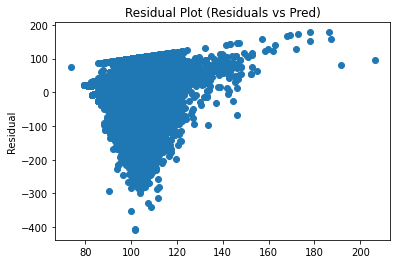

In [29]:
train = hotel_df.copy()
train.pop('adr')

preds = fitted.predict(train)
plt.scatter(preds, -fitted.resid)
plt.title('Residual Plot (Residuals vs Pred)')
plt.ylabel('Residual')

### Jarque Bera Test for Normality
* Goodness of fit test
* Does the sample data have skewness & kurtosis of a normal distribution
* The statistic is always positive, and when far from zero, it signals non-normality

In [30]:
cols = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(fitted.resid)
pd.DataFrame(zip(cols, test)).T

,0,1,2,3
0,Jarque-Bera,Chi^2 two-tail prob.,Skew,Kurtosis
1,39195.1,0,0.952043,5.06244


## E (rror Constant)
* Homoskedasticity vs Heteroskedasticity
 * Example - As income goes up our predicted error increases
 * Example - As we play more minutes of basketball our predicted scoring error increases
* Typically spot with visual plot of residual vs predicted value (look for cone shape)
* If find heteroskedasticity we typically:
 * Adjust the model - add / drop featurews
 * Box Cox (log / sqrt / power) transforms on features and the target

![](https://www.albert.io/blog/wp-content/uploads/2016/11/heteroscedastic-relationships.png)

In [31]:
cols = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(fitted.resid, fitted.model.exog)
pd.DataFrame(zip(cols, test)).T

,0,1,2,3
0,Lagrange multiplier statistic,p-value,f-value,f p-value
1,2662.53,0,907.725,0


### Heteroscedasticity
* Heteroscedasticity doesn't cause bias in coefficients, but it makes them less precise
* Less precise estimates of coefficients are more likely to be farther from a correct population value
* Heteroscedasticity can produce p-values that are smaller than they should be.  OLS can't detect this, and in more pronounced / extreme cases could lead you to conclude a coefficient is significant when it's not.
* Ways to fix / minimize:
  * Redefine Variables - Cross-sectional data changes (i.e. Population vs Per-Capita)
  * Weighted Regression - Weight per observation, assign lower weights to higher values (inverse -- 1 / value -- is typical)
  * Transformations - Convert your dependent variable (log or BoxCox)

## Partial Regression Plots

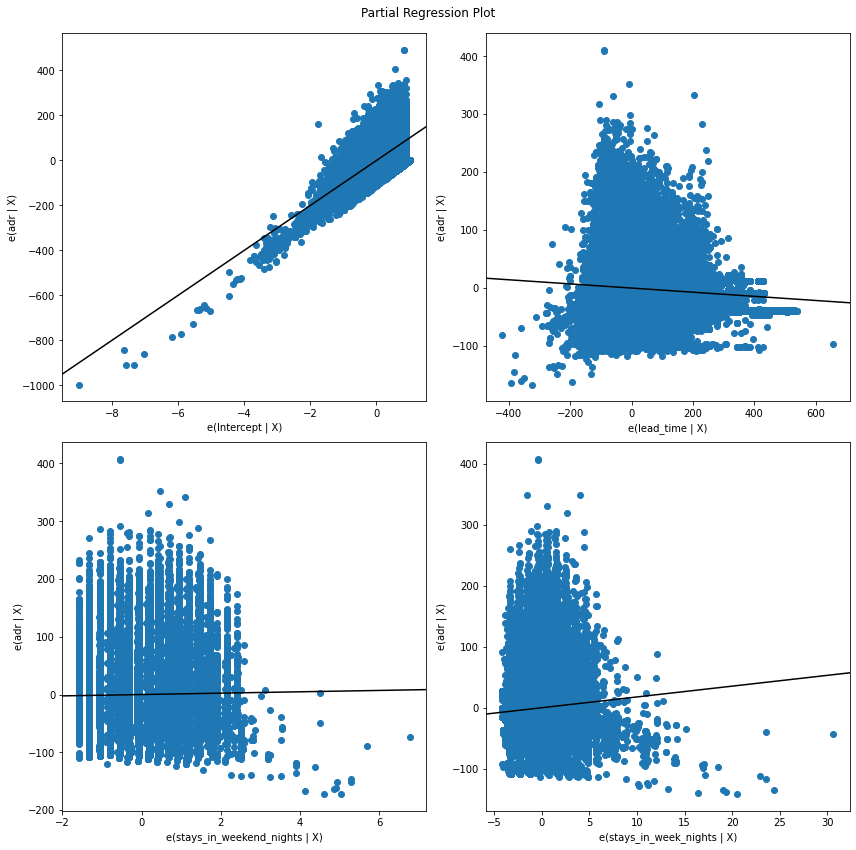

In [32]:
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(fitted, fig=fig)

# Categorical Variables


## Hotel

In [33]:
f = 'adr ~ hotel'
model = smf.ols(formula=f, data=hotel_df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    adr   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1226.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          2.91e-267
Time:                        10:28:15   Log-Likelihood:            -6.3135e+05
No. Observations:              119388   AIC:                         1.263e+06
Df Residuals:                  119386   BIC:                         1.263e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               105.23

## Hotel & Month

In [34]:
f = 'adr ~ hotel + arrival_date_month'
model = smf.ols(formula=f, data=hotel_df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    adr   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     2812.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:28:16   Log-Likelihood:            -6.1710e+05
No. Observations:              119388   AIC:                         1.234e+06
Df Residuals:                  119375   BIC:                         1.234e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Reference Level

In [35]:
f = """adr ~ + C(arrival_date_month, Treatment(reference='January'))
             + C(hotel, Treatment(reference='Resort Hotel'))""" 
model = smf.ols(formula=f, data=hotel_df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    adr   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     2812.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:28:17   Log-Likelihood:            -6.1710e+05
No. Observations:              119388   AIC:                         1.234e+06
Df Residuals:                  119375   BIC:                         1.234e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

# Formulas
* Statsmodels formulas are based on Patsy, a library similar to R formulas
* https://patsy.readthedocs.io/en/latest/formulas.html
* Operator ~
  * Target ~ Regressors
* Operator +
  * Adds regressors to the formula
* Operator -
  * Removes an operator from the formula
  * -1 removes the intercept term
* Categorical
  * Convert to category C(feature_name)
  * Change reference level C(feature_name, Treatment(level))
* Operator *
  * Adds interaction terms to your formula
* Functions
  * np.log(feature_name)
* Sadly, the . operator isn't supported
  * This added all terms from the dataset to the model
  * You'll need to loop over columns to create it
  * ' + '.join(data.cols)
* Excluding levels isn't supported:
  * https://stackoverflow.com/questions/67423950/removing-categories-with-patsy-and-statsmodels
  



# Predictions
* Interpreting Confidence & Prediction Intervals

In [36]:
pred = pd.DataFrame([{'hotel': 'City Hotel', 'arrival_date_month': 'July'}])
pred

,hotel,arrival_date_month
0,City Hotel,July


In [37]:
predictions = fitted.get_prediction(pred)
pred_df = predictions.summary_frame()
pred_df = pred_df.reset_index(drop=True)
pred_df

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,130.191011,0.38948,129.427637,130.954386,46.851099,213.530923
